# Evaluation wrt GT

In [1]:
import numpy as np
import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics

import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
export_path = '/mnt/data/logs/maplab_profiles/'
# export_path = '/media/scratch/berlukas/logs/'
export_path = export_path + 'visual_anymal_5_mission_5_hagerbach/'
n = 4

est_trajectories = []
gt_trajectories = []
config_files = []

for i in range(1, n+1):
    config_filename = export_path + 'config-top-' + str(i) + '.txt'
    est_traj_filename = export_path + 'est-traj-top-' + str(i) + '.npy'
    gt_traj_filename = export_path + 'gt-traj-top-' + str(i) + '.npy'

    config_files.append(config_filename)
    est_trajectories.append(np.load(est_traj_filename))
    gt_trajectories.append(np.load(gt_traj_filename))
assert len(config_files) == len(est_trajectories)
assert len(config_files) == len(gt_trajectories)


--- Translational Part -----------------------------
APE:
{'max': 1.3433342726330253,
 'mean': 0.4396837341233749,
 'median': 0.42169982602804323,
 'min': 0.011344559208263837,
 'rmse': 0.5392122507364956,
 'sse': 418.38903608447265,
 'std': 0.3121346909454998}
RPE:
{'max': 0.2990616880684376,
 'mean': 0.037587721560560235,
 'median': 0.025295726646033984,
 'min': 0.00012318056091141345,
 'rmse': 0.05723882532358399,
 'sse': 0.9402932567096193,
 'std': 0.04316765354185419}



--- Rotational Part -----------------------------
APE:
{'max': 4.011771792018027,
 'mean': 0.9884288076892723,
 'median': 0.8948551761055074,
 'min': 0.031960756193697606,
 'rmse': 1.217946961000629,
 'sse': 2134.605116927551,
 'std': 0.7116201879799586}
RPE:
{'max': 2.7876669546095796,
 'mean': 0.2729390787065282,
 'median': 0.14719884363143498,
 'min': 0.002529516564222054,
 'rmse': 0.43777019458377964,
 'sse': 55.00146731731911,
 'std': 0.34226744306280704}


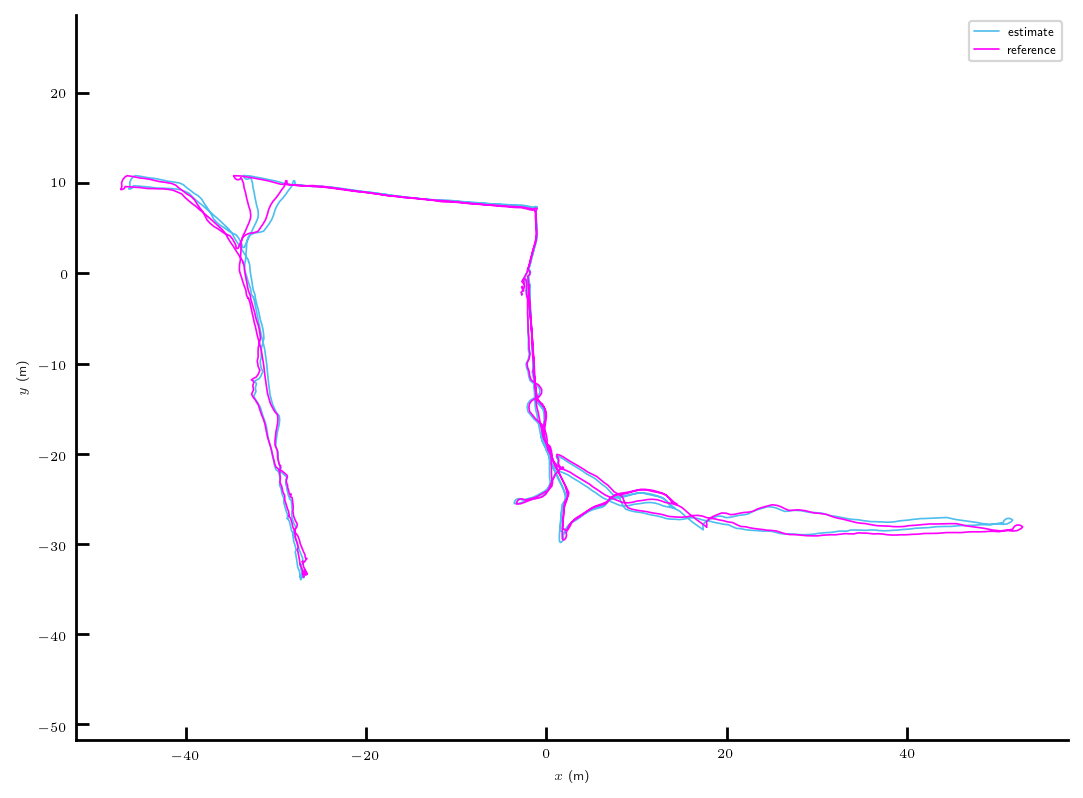

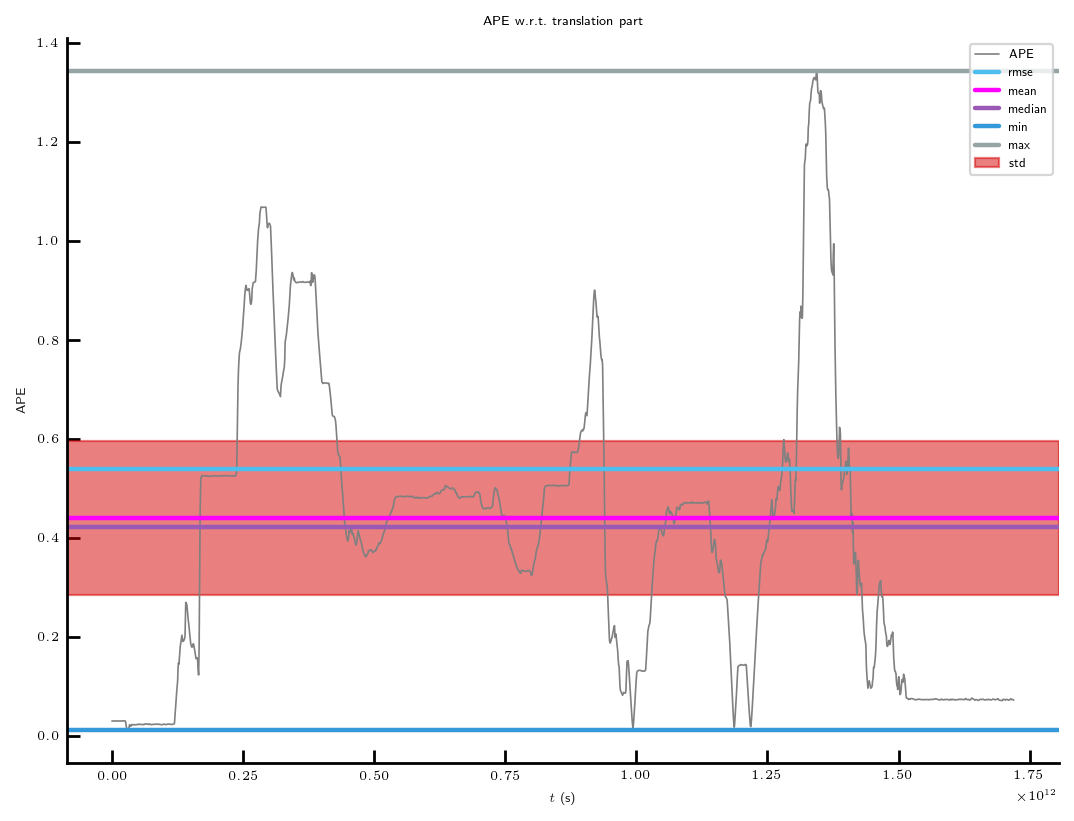

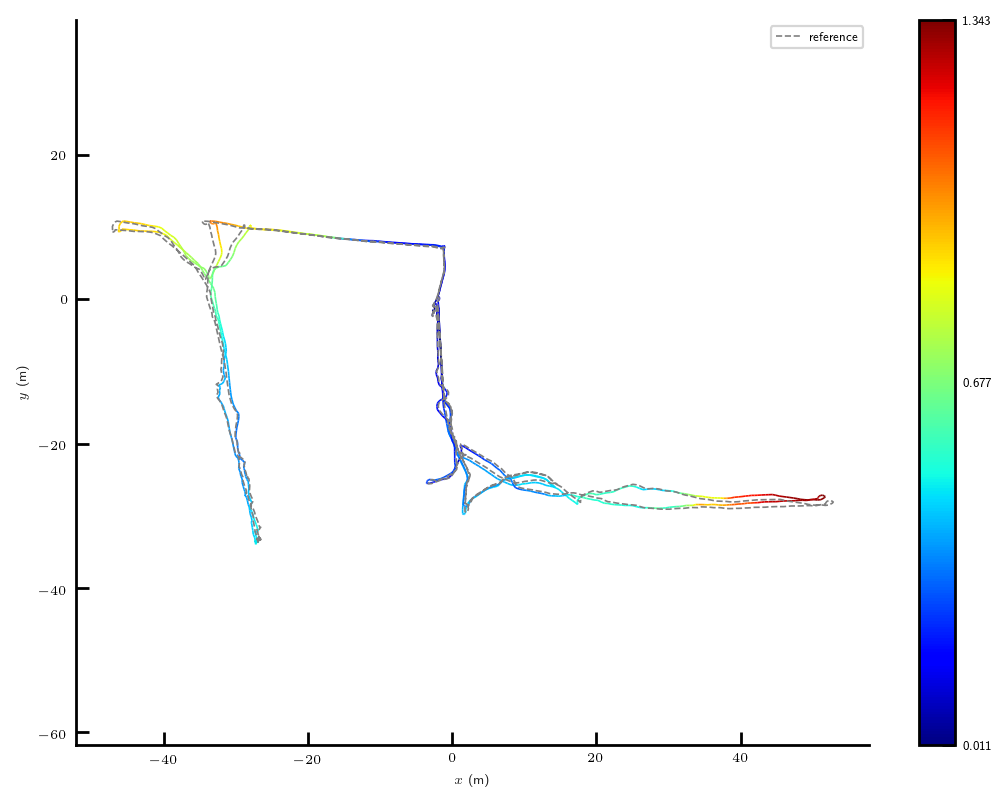

In [4]:
def convert_to_traj(trajectory):
    ts = trajectory[:,0]
    xyz = trajectory[:,1:4]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

idx = 0

est_traj = convert_to_traj(est_trajectories[idx])
gt_traj = convert_to_traj(gt_trajectories[idx])

delta = 5
delta_unit = metrics.Unit.frames
all_pairs = False
data = (gt_traj, est_traj)

print('--- Translational Part -----------------------------')
pose_relation = metrics.PoseRelation.translation_part
print('APE:')
ape_metric_trans = metrics.APE(pose_relation)
ape_metric_trans.process_data(data)
ape_stat_trans = ape_metric_trans.get_statistic(metrics.StatisticsType.rmse)
ape_stats_trans = ape_metric_trans.get_all_statistics()
pprint.pprint(ape_stats_trans)

print('RPE:')
rpe_metric_trans = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric_trans.process_data(data)
rpe_stat_trans = rpe_metric_trans.get_statistic(metrics.StatisticsType.rmse)
rpe_stats_trans = rpe_metric_trans.get_all_statistics()
pprint.pprint(rpe_stats_trans)
print('\n\n')

print('--- Rotational Part -----------------------------')
pose_relation = metrics.PoseRelation.rotation_angle_deg
print('APE:')
ape_metric_rot = metrics.APE(pose_relation)
ape_metric_rot.process_data(data)
ape_stat_rot = ape_metric_rot.get_statistic(metrics.StatisticsType.rmse)
ape_stats_rot = ape_metric_rot.get_all_statistics()
pprint.pprint(ape_stats_rot)

print('RPE:')
rpe_metric_rot = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric_rot.process_data(data)
rpe_stat_rot = rpe_metric_rot.get_statistic(metrics.StatisticsType.rmse)
rpe_stats_rot = rpe_metric_rot.get_all_statistics()
pprint.pprint(rpe_stats_rot)

def plot_evaluations_APE(ape_metric, ape_stats):
    # Trajectory plot
    fig = plt.figure(figsize=(8, 6), dpi=160)
    traj_by_label = {
        "estimate": est_traj,
        "reference": gt_traj
    }
    plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
    plt.show()

    # Trajectory plot
    seconds_from_start = [t - est_traj.timestamps[0] for t in est_traj.timestamps]
    fig = plt.figure(figsize=(8, 6), dpi=160)
    plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                     statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                     name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
    plt.show()

    plot_mode = plot.PlotMode.xy
    fig = plt.figure(figsize=(8, 6), dpi=160)
    ax = plot.prepare_axis(fig, plot_mode)
    plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
    plot.traj_colormap(ax, est_traj, ape_metric.error, 
                       plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
    ax.legend()
    plt.show()
    
plot_evaluations_APE(ape_metric_trans, ape_stats_trans)